In [1987]:
import collections
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

In [1988]:
class SampleSet:
  def __init__(self, Xs: np.ndarray, ys: np.ndarray):
    assert Xs.shape[0] == ys.shape[0]
    self.Xs = Xs
    self.ys = ys
    self.dim = Xs.shape[1] - 1
    self.sample_size = Xs.shape[0]


class SteppingFunction:
  def __init__(self, fun: Callable[[np.ndarray, int], float]):
    assert type(fun(np.array([0, 0, 0]), 10)) is float
    self.fun = fun

  def __call__(self, prev_point: np.ndarray, step_number: int) -> float:
    return self.fun(prev_point, step_number)

class ConvergenceStat:
  def __init__(self, total_epochs: int, total_steps: int, total_points: int):
    self.total_epochs = total_epochs
    self.total_steps = total_steps
    self.total_points = total_points

# Gradient Descent implementation


In [1989]:
def sgd_linear_regression(
        sample_set: SampleSet,
        max_epoch: int,
        eps: float,
        batches: int,
        step_fun: SteppingFunction,
        verbose=False,
        normalize=False
) -> (np.ndarray, ConvergenceStat):
  # y[i] = w[i] * x[i]
  # w' = w - lr * dL / dw
  # L(w) = 1 / l * sum for i in range(1, l) sqr(y[i] - <w, X[i]>)
  # dL / dw = - 1 / l * sum for i in range(1, l) 2 * (y[i] - <w, X[i]>) * X[i]
  sample_size: int = sample_set.sample_size
  dimension: int = sample_set.dim
  w: np.ndarray = np.random.random(dimension + 1)
  ws = [w]

  # Statistics
  total_epochs = 0
  total_steps = 0
  total_points = 0

  # Using moving average of MSE as halt criteria
  moving_average_min = 10
  moving_average_deque = collections.deque()
  moving_average_sum = 0
  Xs = sample_set.Xs.copy()

  if normalize:
    Xs_min = Xs[:, 1:].min(axis=0)
    Xs_max = Xs[:, 1:].max(axis=0)
    Xs[:, 1:] = (Xs[:, 1:] - Xs_min) / (Xs_max - Xs_min)


  for epoch in range(max_epoch):
    perm = np.random.permutation(sample_size)
    X_perm, y_perm = Xs[perm], sample_set.ys[perm]
    batch_size = int(sample_size / batches)
    overall_error = 0
    for batch in range(batches):
      sup_pt_num = batch_size * (batch + 1) if batch < batches - 1 else sample_size
      error = np.zeros(w.shape)
      cnt = 0
      for pt_num in range(batch * batch_size, sup_pt_num):
        pt_x, pt_y = X_perm[pt_num], y_perm[pt_num]
        delta = pt_y - w.dot(pt_x)
        error += -2 * delta * pt_x
        cnt += 1
        overall_error += delta ** 2
        total_points += 1
      error /= cnt
      lr = step_fun(w, len(ws))
      w -= lr * error
      ws.append(w)
      total_steps += 1

    total_epochs += 1

    # Halt criteria
    overall_error /= sample_size

    if epoch > moving_average_min:
      mov_error = moving_average_sum / len(moving_average_deque)
      if abs(overall_error - mov_error) < eps:
        if verbose:
          print("Stopped due to halt criteria")
        break

    moving_average_deque.append(overall_error)
    moving_average_sum += overall_error
    if len(moving_average_deque) > moving_average_min:
      tail = moving_average_deque.popleft()
      moving_average_sum -= tail

  return np.array(ws), ConvergenceStat(total_epochs, total_steps, total_points)


In [1990]:
np.array([[1, 2], [2, 4], [4, 5], [6, 7]]).shape

(4, 2)

# Generate samples

In [1991]:
import enum


class NoiseLevel:
  class NoiseKind(enum.Enum):
    NEIGHBOURHOOD = 1
    UNIFORM = 2

  def __init__(self, kind: NoiseKind, min_lvl: float, max_lvl: float):
    assert (kind == NoiseLevel.NoiseKind.UNIFORM and min_lvl == max_lvl
            or kind == NoiseLevel.NoiseKind.NEIGHBOURHOOD and min_lvl <= max_lvl)
    self.min_lvl = min_lvl
    self.max_lvl = max_lvl
    self.kind = kind

Here we can see method that generates sample set along with task itself (parameter w to be found)

There are two modes in which we can generate samples: NEIGHBOURHOOD and UNIFORM

UNIFORM mode just adds uniformly distributed random variable to purely evaluated point

NEIGHBOURHOOD takes point from current point's neighbourhood and evaluates it purely

In [1992]:
def generate_samples(n: int, x_dim: int, noise_level: NoiseLevel, const_bound: float, bounds: np.ndarray) -> (SampleSet, np.ndarray):
  assert x_dim > 0
  assert bounds.shape == (x_dim, )
  fun: Callable[[np.ndarray], float]

  if noise_level.kind == NoiseLevel.NoiseKind.NEIGHBOURHOOD:
    # Configure noise levels along each axis
    if x_dim == 1 and noise_level.max_lvl != noise_level.min_lvl:
      print("Warning: noise_level.min_lvl may not be present in noise_levels")
    noise_levels = np.random.random(x_dim + 1) * (noise_level.max_lvl - noise_level.min_lvl) + noise_level.min_lvl

    # Ensure that maximum and minimum noise levels are feasible
    noise_levels[1] = noise_level.min_lvl
    noise_levels[-1] = noise_level.max_lvl

    fun = lambda x: w.dot(x * (1 + noise_levels * np.random.random(1) * const_bound))
  elif noise_level.kind == NoiseLevel.NoiseKind.UNIFORM:
    noise = noise_level.min_lvl
    fun = lambda x: w.dot(x) + noise * (np.random.random(1) - 0.5) * const_bound
  else:
    assert False, "Unreachable statement"

  # Randomly generate w vector of numbers [0, 1],
  # yet free constant should be in [-l1_bound / 2; l1_bound / 2]
  w: np.ndarray = np.random.random(x_dim + 1)
  w[0] = np.random.random(1) * const_bound / 2

  Xs: [np.ndarray] = []
  ys: [float] = []

  for i in range(n):
    # Ensure that free constant is indeed independent of sample
    x: np.ndarray = np.random.random(x_dim) * bounds
    x = np.insert(x, 0, -1)

    y = fun(x)

    Xs.append(x)
    ys.append(y)

  return SampleSet(np.array(Xs), np.array(ys)), w

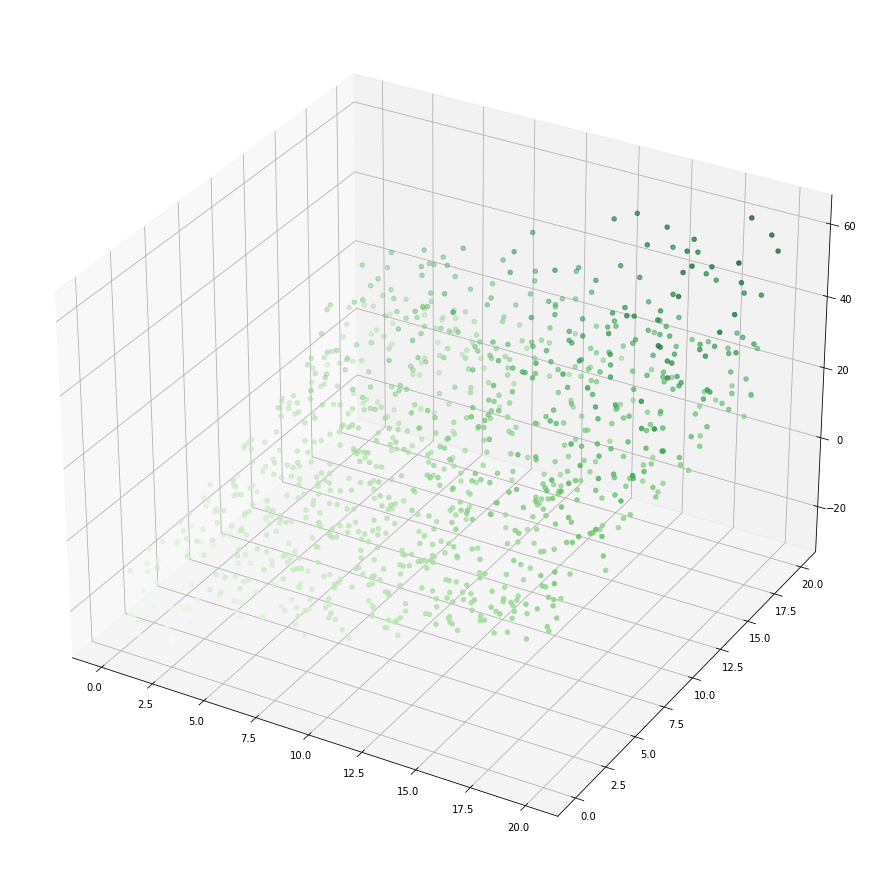

In [1993]:
def draw_example_neighbourhood():
  sample_set, _ = generate_samples(1000, 2, NoiseLevel(NoiseLevel.NoiseKind.NEIGHBOURHOOD, 0.1, 0.2), 20, np.array([20, 20]))
  x_data, y_data = sample_set.Xs[:, 1], sample_set.Xs[:, 2]
  z_data = sample_set.ys

  ax = plt.axes((0, 0, 3, 3), projection='3d')
  ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='Greens')


draw_example_neighbourhood()

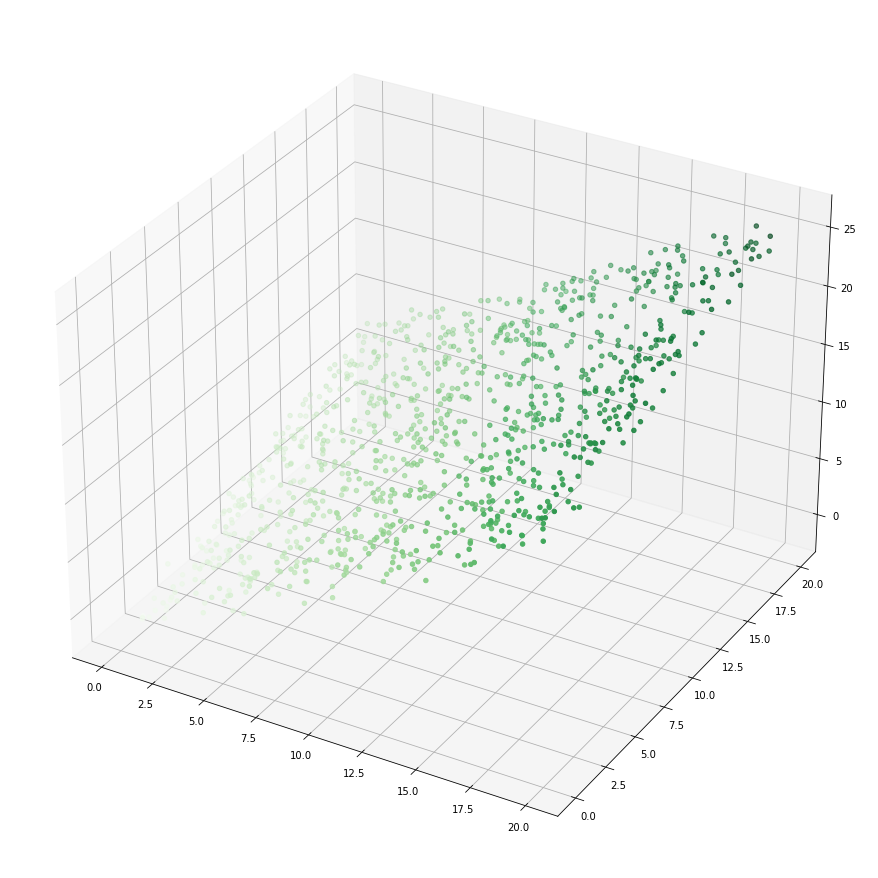

In [1994]:
def draw_example_uniform():
  sample_set, _ = generate_samples(1000, 2, NoiseLevel(NoiseLevel.NoiseKind.UNIFORM, 0.1, 0.1), 20, np.array([20, 20]))
  x_data, y_data = sample_set.Xs[:, 1], sample_set.Xs[:, 2]
  z_data = sample_set.ys

  ax = plt.axes((0, 0, 3, 3), projection='3d')
  ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='Greens')


draw_example_uniform()

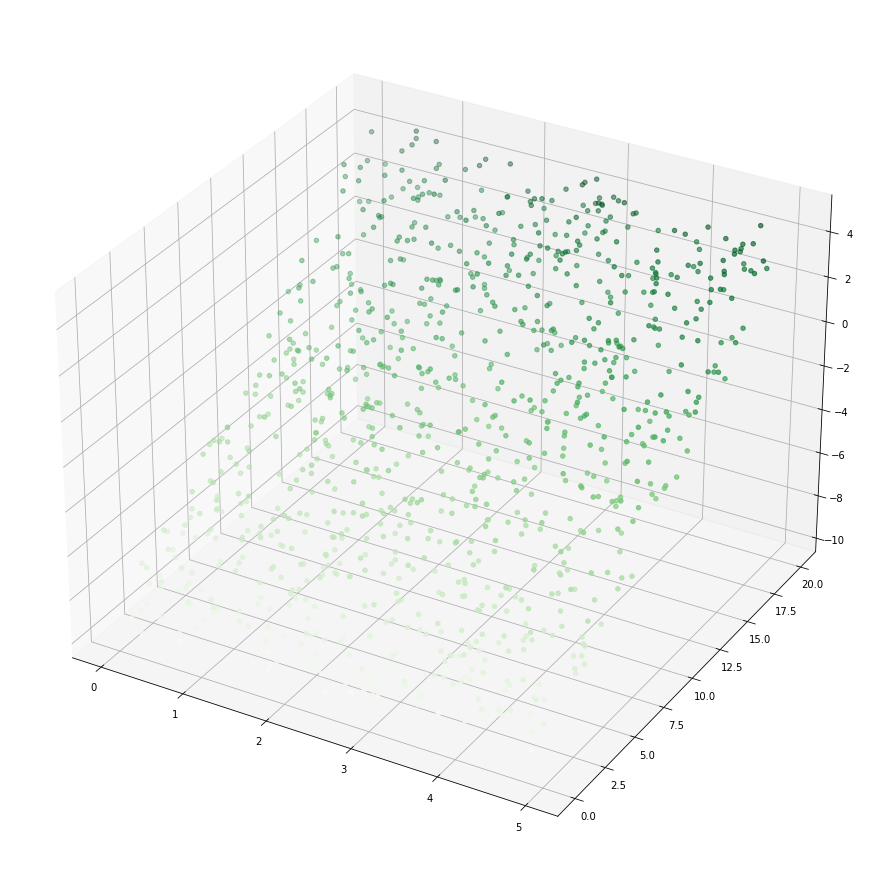

In [1995]:
def draw_example_uniform_denormalized():
  sample_set, _ = generate_samples(1000, 2, NoiseLevel(NoiseLevel.NoiseKind.UNIFORM, 0.1, 0.1), 20, np.array([5, 20]))
  x_data, y_data = sample_set.Xs[:, 1], sample_set.Xs[:, 2]
  z_data = sample_set.ys

  ax = plt.axes((0, 0, 3, 3), projection='3d')
  ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='Greens')


draw_example_uniform_denormalized()

# Test of SGD

Here we can see special case with dimension 2 and how naive SGD handles it

Sometimes it really does work correctly, but sometimes guessed surface is far from
true one.

Green dots are points from sample set, blue surface is the guessed surface by SGD

Stopped due to halt criteria
sgd_path consists of 373 vectors


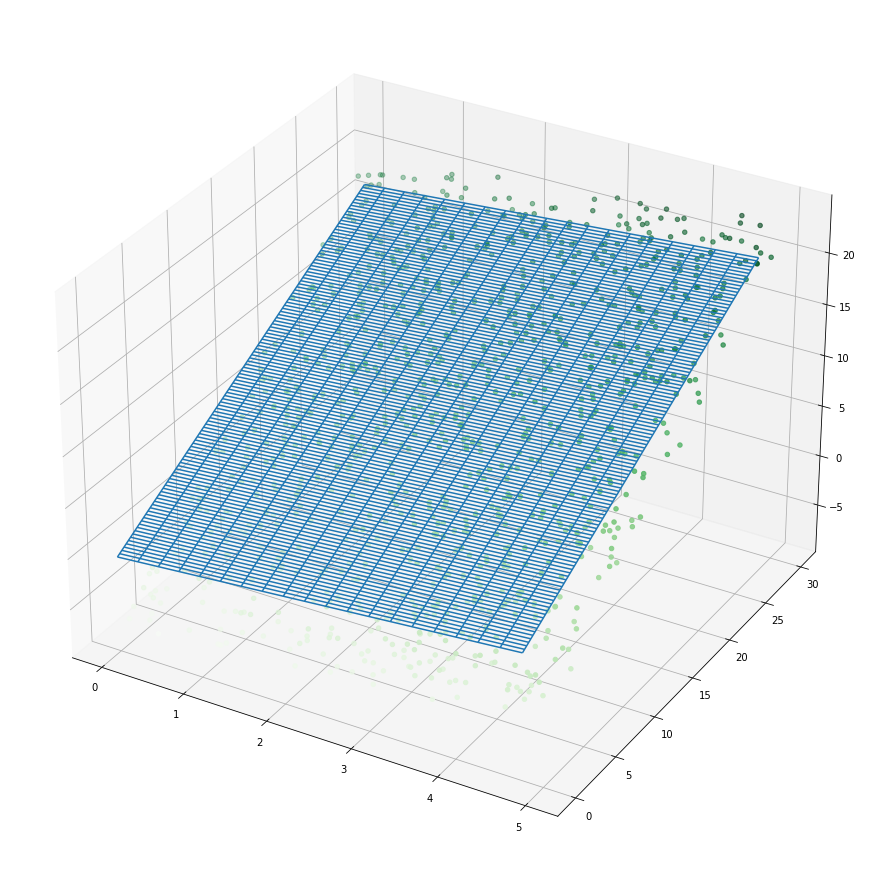

In [1996]:
def test_sgd_uniform_noise():
  sample_size = 1000
  x_dim = 2
  const_bound = 20
  x_bound = 5
  y_bound = 30
  bounds = np.array([x_bound, y_bound])

  sample_set, w_true = generate_samples(sample_size, x_dim, NoiseLevel(NoiseLevel.NoiseKind.UNIFORM, 0.2, 0.2), const_bound, bounds)
  x_data, y_data = sample_set.Xs[:, 1], sample_set.Xs[:, 2]
  z_data = sample_set.ys

  step_fun = SteppingFunction(lambda prev_x, step_num: 0.001 ** ((1 + step_num) // 2))

  sgd_path, _ = sgd_linear_regression(sample_set, 40, 0.00001, int(np.sqrt(sample_size)), step_fun, verbose=True)
  print(f"sgd_path consists of {len(sgd_path)} vectors")
  w_sgd: np.ndarray = sgd_path[-1]
  x_sgd = np.arange(0, x_bound, 0.25)
  y_sgd = np.arange(0, y_bound, 0.25)

  z_sgd = np.array([[np.array([-1, x, y]).dot(w_sgd) for x in x_sgd] for y in y_sgd])
  x_sgd, y_sgd = np.meshgrid(x_sgd, y_sgd)
  ax = plt.axes((0, 0, 3, 3), projection='3d')
  ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='Greens')
  ax.plot_wireframe(x_sgd, y_sgd, z_sgd, rstride=1, cstride=1)

test_sgd_uniform_noise()

# Convergence investigation

Here is dependency of three convergence characteristics: number of epochs, number of steps
and number of points evaluated, on batch count. As we can see, there are several local minima
for points evaluated.

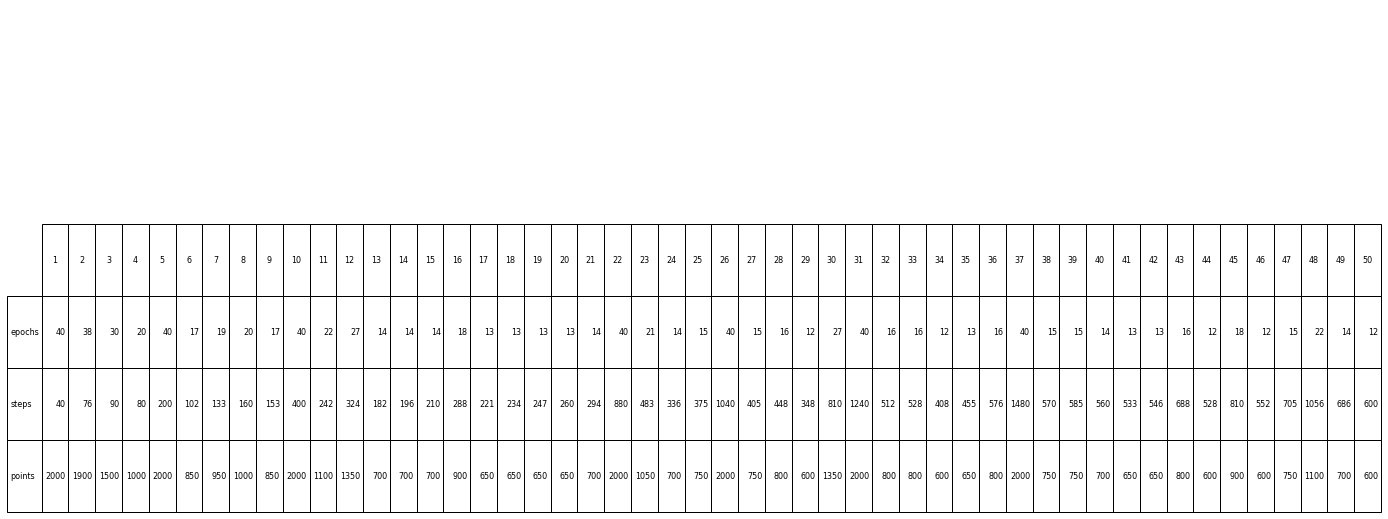

In [1997]:
def convergence_investigation():
  sample_size = 50
  x_dim = 10
  const_bound = 20
  bounds = np.array([5 * i for i in range(1, 11)])

  sample_set, w_true = generate_samples(sample_size, x_dim, NoiseLevel(NoiseLevel.NoiseKind.UNIFORM, 0.2, 0.2), const_bound, bounds)

  step_fun = SteppingFunction(lambda prev_x, step_num: 0.001 ** ((1 + step_num) // 5))
  # step_fun = SteppingFunction(lambda prev_x, step_num: float(0.05 / np.sqrt(step_num)))
  stats = []
  col_labels = []

  for batch_size in range(1, sample_size + 1):
    sgd_path, stat = sgd_linear_regression(sample_set, 40, 0.000001, batch_size, step_fun)
    stats.append([stat.total_epochs, stat.total_steps, stat.total_points])
    col_labels.append(batch_size)

  stats = np.array(stats).transpose()
  fig, ax = plt.subplots()
  ax.set_axis_off()
  tbl = ax.table(stats, rowLabels=["epochs", "steps", "points"], colLabels=col_labels)
  tbl.scale(4, 6)
  plt.show()


convergence_investigation()

# Normalized sample set convergence investigation

For normalized sample set picture is the same, except almost everywhere number
of epochs is less than for non-normalized sample set, so convergence is better.

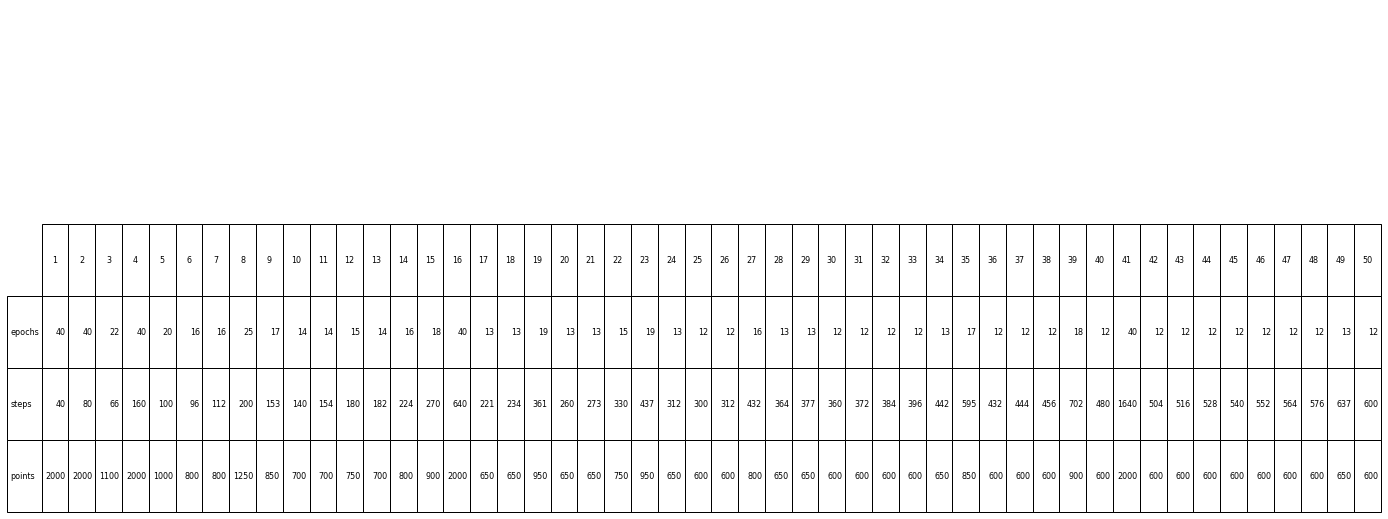

In [1998]:
def convergence_investigation_normalized():
  sample_size = 50
  x_dim = 10
  const_bound = 20
  bounds = np.array([5 * i for i in range(1, 11)])

  sample_set, w_true = generate_samples(sample_size, x_dim, NoiseLevel(NoiseLevel.NoiseKind.UNIFORM, 0.2, 0.2), const_bound, bounds)

  step_fun = SteppingFunction(lambda prev_x, step_num: 0.001 ** ((1 + step_num) // 5))
  stats = []
  col_labels = []

  for batch_size in range(1, sample_size + 1):
    sgd_path, stat = sgd_linear_regression(sample_set, 40, 0.0000001, batch_size, step_fun, normalize=True)
    stats.append([stat.total_epochs, stat.total_steps, stat.total_points])
    col_labels.append(batch_size)

  stats = np.array(stats).transpose()
  fig, ax = plt.subplots()
  ax.set_axis_off()
  tbl = ax.table(stats, rowLabels=["epochs", "steps", "points"], colLabels=col_labels)
  tbl.scale(4, 6)
  plt.show()


convergence_investigation_normalized()